## State preparation

Many quantum algorithms require specific initial states in oredr to run correctly. In this tutorial we show how an arbitrary state can be prepared using pulse sequence optimization capabilities of `pulser-diff`.

In [1]:
import torch

from torch import Tensor
from pulser import Sequence, Pulse, Register 
from pulser.devices import VirtualDevice
from pulser.waveforms import CustomWaveform
from pulser.channels import Rydberg

from pulser_diff.model import QuantumModel

from pyqtorch.utils import SolverType

from math import pi, sin
from pulser_diff.utils import basis_state, interpolate_sine


MockDevice = VirtualDevice(
    name="MockDevice",
    dimensions=2,
    rydberg_level=60,
    channel_objects=(
        Rydberg.Global(6.28, 12.566370614359172, max_duration=None),
    ),
)

Let us first define a 6-qubit register.

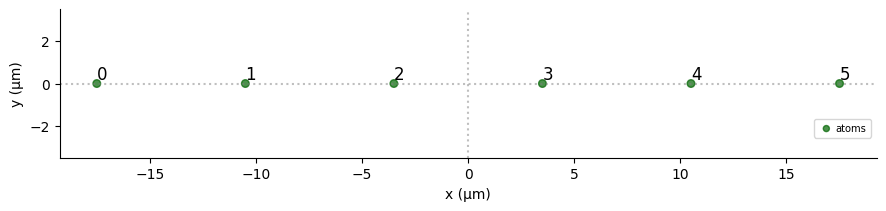

In [2]:
dist = torch.tensor([7.0])
n_qubits = 6
reg = Register.rectangle(1, n_qubits, dist)
reg.draw()

In this simulation we choose the state $\ket{1...1}$ as the target state whereas we start from the zero state $\ket{0...0}$. The measure of state similarity is defined as the state fidelity $F=|\left.\left\langle \psi_{\rm{init}}\right| \psi_{\rm{target}} \right\rangle |^2$ and consequently, the optimization loss is given by $L=1-F$.

In [3]:
# define |1...1> target state
target_state = basis_state(2 ** n_qubits, 2 ** n_qubits - 1).to(dtype=torch.complex128)

def fidelity(state1: Tensor, state2: Tensor) -> Tensor:
    return torch.abs(torch.matmul(state1.mH, state2)) ** 2

We will use custom-pulse sequence with amplitude and detuning waveforms constructed using sine function interpolation.


call_param_values.amp_custom_0
Parameter containing:
tensor([-0.4238,  0.9032, -0.4445,  0.4244,  0.0445,  0.6037, -0.6713, -0.6366,
        -0.5362, -0.4648, -0.6841, -0.0158, -0.3719,  0.1015,  0.5957, -0.7906,
         0.2809, -0.7134, -0.8567, -0.1148, -0.9961,  0.6875, -0.5686, -0.2658,
         0.8687, -0.2460,  0.2714,  0.7321,  0.0317,  0.0554],
       requires_grad=True)
-------
call_param_values.det_custom_0
Parameter containing:
tensor([-0.6176, -0.4191,  0.4568,  0.0798, -0.9386,  0.4955,  0.3586,  0.8165,
         0.2952, -0.2753,  0.3597,  0.6919, -0.8260,  0.4882,  0.3827,  0.5242,
        -0.6748, -0.2612, -0.7674, -0.6626,  0.1588, -0.0735, -0.1570,  0.0700,
         0.6961,  0.3951, -0.6370,  0.3671, -0.0192, -0.1278],
       requires_grad=True)
-------


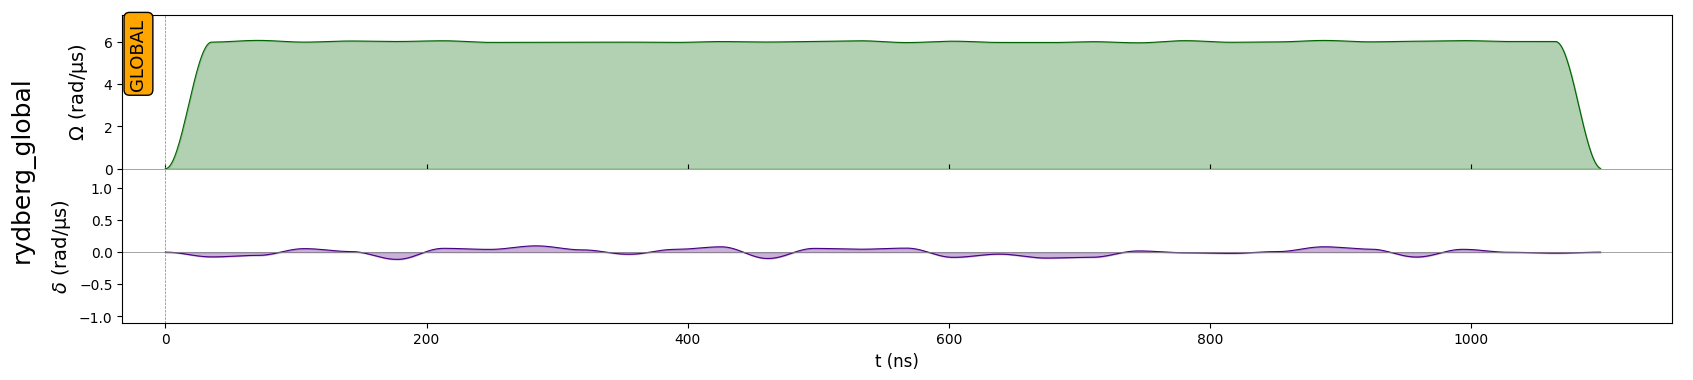

In [4]:
duration = 1100
n_param = 30

# create sequence and declare channels
seq = Sequence(reg, MockDevice)
seq.declare_channel("rydberg_global", "rydberg_global")

# define custom-shaped pulse
amp_custom_param = seq.declare_variable("amp_custom", size=duration)
det_custom_param = seq.declare_variable("det_custom", size=duration)
cust_amp = CustomWaveform(amp_custom_param)
cust_det = CustomWaveform(det_custom_param)
pulse_custom = Pulse(cust_amp, cust_det, 0.0)

# add pulse
seq.add(pulse_custom, "rydberg_global")

# create sine interpolation matrix
interp_mat = interpolate_sine(n_param, duration)

def custom_wf_amp(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_amp) * torch.sigmoid(params / 50))

def custom_wf_det(params):
    return torch.matmul(interp_mat, int(MockDevice.channels["rydberg_global"].max_abs_detuning) * torch.tanh(params / 50))

# define pulse parameters
amp_values = 2 * torch.rand(n_param, requires_grad=True) - 1.0
det_values = 2 * torch.rand(n_param, requires_grad=True) - 1.0
trainable_params = {
    "amp_custom": ((amp_values,), custom_wf_amp),
    "det_custom": ((det_values,), custom_wf_det),
}

# create quantum model from sequence
model = QuantumModel(seq, trainable_params, sampling_rate=0.05, solver=SolverType.DP5_SE)

# list trainable parameters of the model
print()
for name, param in model.named_parameters():
    print(name)
    print(param)
    print('-------')

model.built_seq.draw()

Finally, we run the optimization loop and record the best parameter set giving the lowest loss.

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=5.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
epochs = 1000
min_change = 0.01
num_loss_plateu = 6

loss_dict = {}
for t in range(epochs):
    # calculate loss
    _, final_state = model.forward()
    loss = 1 - fidelity(target_state, final_state[-1])
    
    # backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # log the loss value together with model params
    loss_dict[t] = {"loss": float(loss), "params": {name: param.data.clone().detach() for name, param in model.named_parameters()}}

    if len(loss_dict) > num_loss_plateu and loss > 0.1:
        last_losses = [loss_dict[i]["loss"] for i in range(t-num_loss_plateu, t + 1)]
        diffs = [abs(last_losses[i] - last_losses[i - 1]) for i in range(-1, -num_loss_plateu-1, -1)]
        if all(diff < min_change for diff in diffs):
            print(f"Epoch {t}: loss plateaued — scheduler's LR is reset.")

            # Update learning rate
            scheduler.step(epoch=0)
        
        else:
            # Update learning rate
            scheduler.step()

    else:
        # Update learning rate
        scheduler.step()

    # Print learning rate
    lr = scheduler.get_last_lr()[0]
    print(f"Epoch {t:03}: Learning Rate = {lr:.6f}")

    if loss < 0.0001:
        print(f"[t={t}]loss: {float(loss):>7f}")
        break

    # update sequence with changed pulse parameter values
    model.update_sequence()

    print(f"[t={t}]loss: {float(loss):>7f}")
    print("**************************************")

# get best parameter set
sorted_losses = dict(sorted(loss_dict.items(), key=lambda x: x[1]["loss"]))
best_param_set = list(sorted_losses.values())[0]["params"]
print(f"Best loss: {list(sorted_losses.values())[0]['loss']} after {list(sorted_losses.keys())[0]} epochs.")

Epoch 000: Learning Rate = 4.995067
[t=0]loss: 0.992051
**************************************
Epoch 001: Learning Rate = 4.980287
[t=1]loss: 0.967682
**************************************
Epoch 002: Learning Rate = 4.955718
[t=2]loss: 0.913183
**************************************
Epoch 003: Learning Rate = 4.921458
[t=3]loss: 0.815916
**************************************
Epoch 004: Learning Rate = 4.877641
[t=4]loss: 0.678294
**************************************
Epoch 005: Learning Rate = 4.824441
[t=5]loss: 0.522670
**************************************
Epoch 006: Learning Rate = 4.762068
[t=6]loss: 0.385587
**************************************
Epoch 007: Learning Rate = 4.690767
[t=7]loss: 0.285439
**************************************
Epoch 008: Learning Rate = 4.610820
[t=8]loss: 0.213881
**************************************
Epoch 009: Learning Rate = 4.522542
[t=9]loss: 0.160143
**************************************
Epoch 010: Learning Rate = 4.426283
[t=10]loss: 0.

In [6]:
# update model params with the best optimized parameter values
for n, p in model.named_parameters():
    p.data = best_param_set[n]
model.update_sequence()

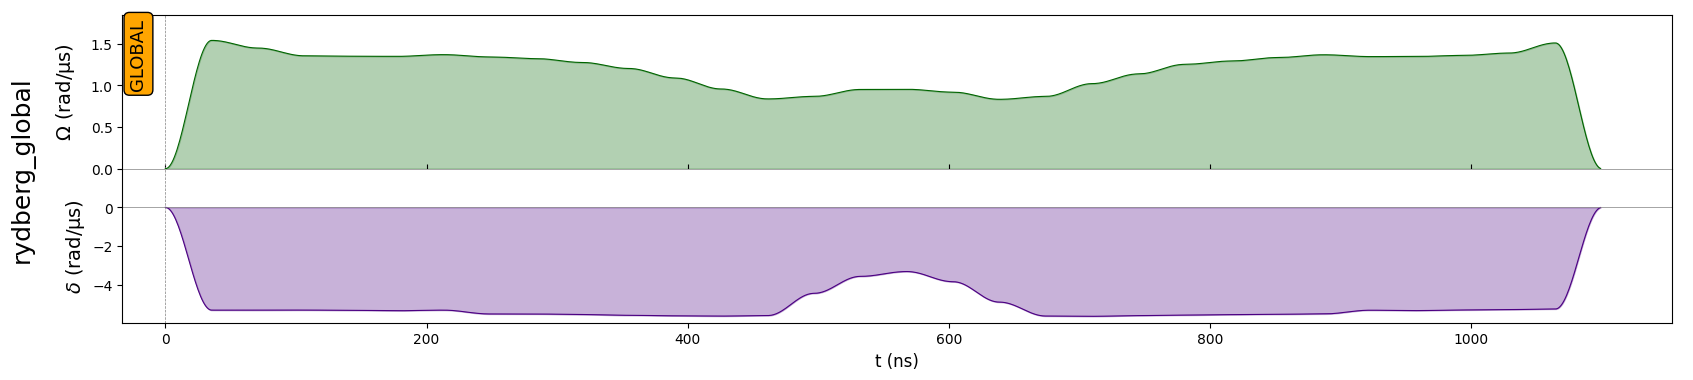

call_param_values.amp_custom_0
Parameter containing:
tensor([ -95.8657,  -99.3746, -103.1411, -103.3391, -103.4215, -102.5601,
        -103.6927, -104.5593, -106.5585, -109.7892, -115.2750, -122.3679,
        -129.5513, -127.6241, -122.6902, -122.5654, -124.5585, -129.8573,
        -127.6328, -118.8225, -112.8829, -107.5464, -105.7980, -104.0191,
        -102.6253, -103.5339, -103.4682, -102.9382, -101.7739,  -97.0190],
       requires_grad=True)
----------------
call_param_values.det_custom_0
Parameter containing:
tensor([-69.8246, -69.9671, -69.6974, -70.1901, -71.0153, -69.8163, -78.6302,
        -78.7660, -80.3153, -82.5495, -84.1735, -85.1208, -83.3509, -47.5117,
        -34.1823, -31.0943, -37.9117, -57.1670, -84.9613, -85.9290, -83.5173,
        -81.8508, -80.5201, -79.4766, -78.5061, -69.9876, -70.7386, -69.4575,
        -68.7406, -67.6137], requires_grad=True)
----------------
State fidelity: 99.99%


In [7]:
# visualize the optimized custom pulse
model.built_seq.draw(draw_phase_curve=True)

for name, param in model.named_parameters():
    print(name)
    print(param)
    print("----------------")

_, final_state = model.forward()
print(f"State fidelity: {100 * float(fidelity(final_state[-1], target_state)):.2f}%")

We can see that that executing the pulse with the optimized custom waveform displayed above results in the transformation $\ket{0...0} \rightarrow \ket{1...1}$ with 99.99% accuracy in the presence of inter-qubit interaction.